<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Дополнение-таблицы" data-toc-modified-id="Дополнение-таблицы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Дополнение таблицы</a></span></li><li><span><a href="#Исследовательский-анализ-данных-и-выполнение-инструкции-заказчика" data-toc-modified-id="Исследовательский-анализ-данных-и-выполнение-инструкции-заказчика-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных и выполнение инструкции заказчика</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(df.info())
print()

print(df.describe())
print()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

**Вывод**   
Пропущенные значение есть во многих столбцах. Возможно это связано с ошибками оператора, который записывал значения в таблицу. Еще возможны ошибки выгрузки. Пропуски в столбцах расстояние до центра, аэропорта, ближайшего парка и водоёма можно объснить тем, что не все квартиры имели картографические данные.  
В значениях столца ceiling_height  есть аномально маленькие (1м) и аномально большие (100м) значения.

### Предобработка данных

In [2]:
#Изучим отдельно аномально низкие и высокие потолки:
df1=df.query('ceiling_height<2.4 or ceiling_height>=4.5')
print('Непрадоподнобных потолков:', len(df1))
print()
#Их немного, удалим их

def ceiling(row):
    if row['ceiling_height']==row['ceiling_height'] and row['ceiling_height']>=2.4 and row['ceiling_height']<4.5:
        return row['ceiling_height']

df['ceiling_height']=df.apply(ceiling, axis=1)

#Количество NaN в ceiling_height увеличилось на кол-во неправдоподобных ceiling_height
#Заполим пропуски в ceiling_height в зависимости от этажност здания

#Категоризиуем столбец с количеством этажей
def categoryzation(row):
    i=row['floors_total']
    if i<5:
        return 'малоэтажка'
    if i<16:
        return 'многоэтажка'
    if i<45:
        return 'высотка'
    if i<=60:
        return 'небоскреб'
    else:
        return 'unknown'

df['hight_type']=df.apply(categoryzation, axis=1) 

#Найдем средние значения ceiling_height для каждой группы hight_type
log = df.groupby('hight_type').agg({'ceiling_height':['median'],'total_images':['count']}).reset_index()
log.columns=['hight_type', 'ceiling_height_median', 'count']
print(log)

#Создадим ф-ию для замены пропусков ceiling_height:
def func(row):
    if row['ceiling_height']==row['ceiling_height']:
        return row['ceiling_height']
    else:
        if row['hight_type']=='малоэтажка':
            return log.loc[2, 'ceiling_height_median']
        elif row['hight_type']=='многоэтажка':
            return log.loc[3, 'ceiling_height_median']
        elif row['hight_type']=='высотка':
            return log.loc[1, 'ceiling_height_median']
        elif row['hight_type']=='небоскреб':
            return log.loc[4, 'ceiling_height_median']
        elif row['hight_type']=='unknown':
            return log.loc[0, 'ceiling_height_median']

df['ceiling_height']=df.apply(func, axis=1)

#Изменим все буквы на строчные и заменим ё на е
df['locality_name']=df['locality_name'].str.lower()
df['locality_name']=df['locality_name'].str.replace('ё', 'е')

#Заменим NaN в количестве балконов на 0
df['balcony']=df['balcony'].fillna(0)


#Замена типов данных
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['balcony']=df['balcony'].astype('int')


Непрадоподнобных потолков: 70

    hight_type  ceiling_height_median  count
0      unknown                  2.800     86
1      высотка                  2.700   6004
2   малоэтажка                  2.850   2276
3  многоэтажка                  2.600  15331
4    небоскреб                  2.765      2


**Вывод**   
Я изучила аномальные значения ceiling_height (меньше 2.4 м и больше 4.5 м), их немного, поэтому я их удалила. После заполнила пропуски ceiling_height медианами в зависимости от этажности здания. 

В названии населнных пунктов locality_name есть дубликаты с разным написанием букв. Чтобы это не мешало в дальнейших исследованиях я перевела все буквы в строчные и заменила буквы "ё" на "е".

В стобце balcony пропуски скорее всего можно объясним тем, что в этих квартирах балконов нет. Эти пропуски заменила на 0. 

Я изменила тип данных в столбце first_day_exposition на datetime, потому что так будет удобнее работать с датами.

Остальные пропуски оставила без изменений.


###  Дополнение таблицы

In [3]:
#Цена квадратного метра
df['m2_price']=df['last_price']/df['total_area']

#день недели, месяц и год публикации объявления
df['weekday']=df['first_day_exposition'].dt.weekday
df['month']=df['first_day_exposition'].dt.month
df['year']=df['first_day_exposition'].dt.year

#этаж квартиры; варианты — первый, последний, другой;
def cat(row):
    if row['floor']==1:
        return 'первый'
    if row['floor']==row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_category']=df.apply(cat, axis=1)

#соотношение жилой и общей площади, а также отношение площади кухни к общей
df['living_total_ratio']=df['living_area']/df['total_area']
df['kitchen_total_ratio']=df['kitchen_area']/df['total_area']
#print(df.head())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 30 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

**Вывод**   
Посчитала и добавила в таблицу:
цену квадратного метра, день недели, месяц и год публикации объявления;
тип этажа квартиры;
соотношение жилой и общей площади, а также отношение площади кухни к общей.

###  Исследовательский анализ данных и выполнение инструкции заказчика

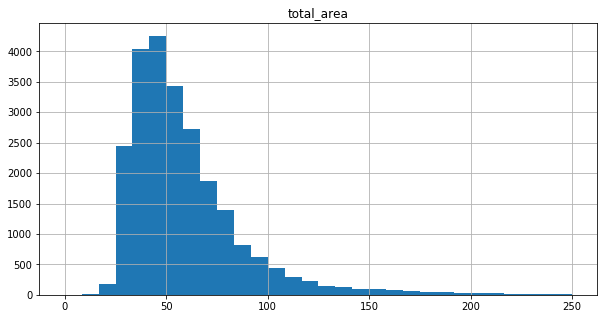

Минимальное значение total_area 12.0
Максимальное значение total_area 900.0


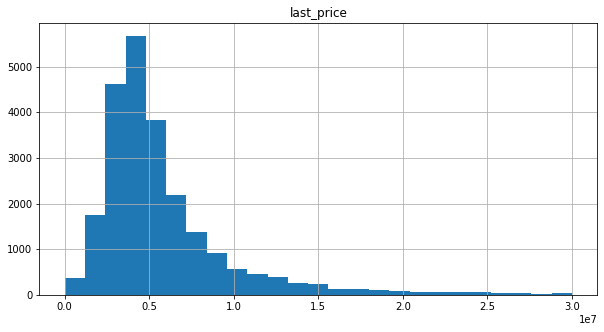

Минимальное значение last_price 12190.0
Максимальное значение last_price 763000000.0


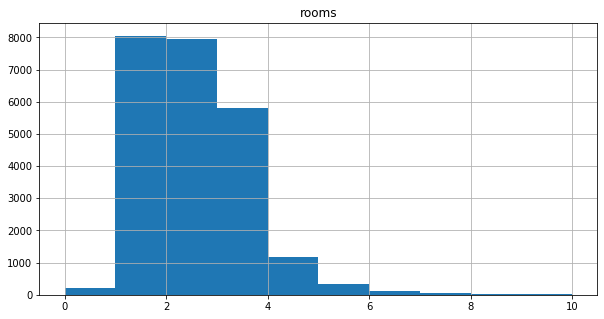

Минимальное значение rooms 0
Максимальное значение rooms 19


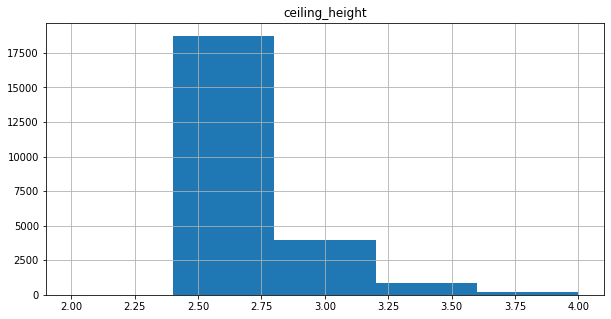

Минимальное значение ceiling_height 2.4
Максимальное значение ceiling_height 4.45



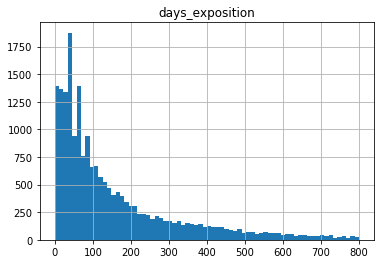

Минимльное время продажи квартиры: 1.0
Максимальное время продажи квартиры: 1580.0
Среднее время продажи квартиры: 180.88863436982163
Медианное время продажи квартиры: 95.0
За первую неделю продаётся квартир: 3.58%

Посмотрим коэф-ты корреляции с ценой:
last_price             1.000000
m2_price               0.736499
total_area             0.653675
living_area            0.566492
kitchen_area           0.519869
rooms                  0.363343
ceiling_height         0.263640
ponds_around3000       0.159996
parks_around3000       0.151058
total_images           0.104473
days_exposition        0.081146
floor                  0.026576
balcony                0.008559
month                  0.002779
living_total_ratio     0.002501
weekday                0.001550
floors_total          -0.006984
open_plan             -0.008802
parks_nearest         -0.016414
studio                -0.025362
airports_nearest      -0.026239
year                  -0.043089
ponds_nearest         -0.084809
kitchen_to

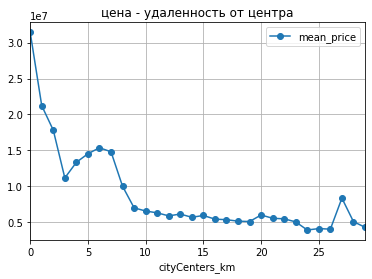

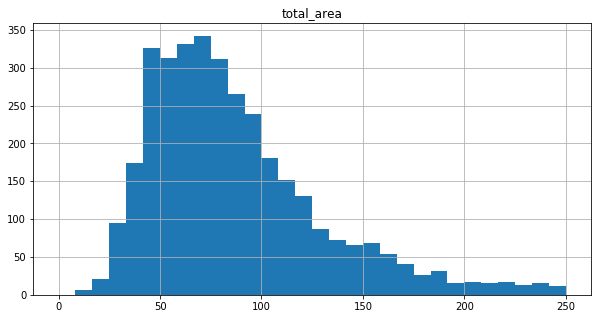

Минимальное значение total_area 12.0
Максимальное значение total_area 631.2


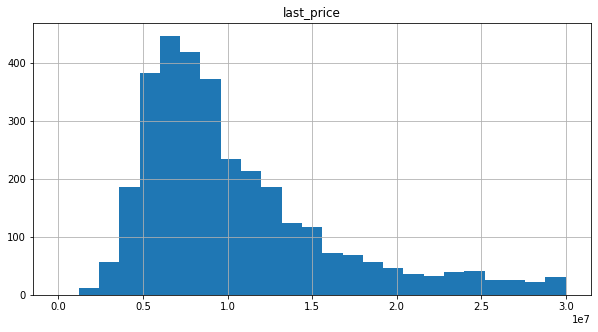

Минимальное значение last_price 1600000.0
Максимальное значение last_price 763000000.0


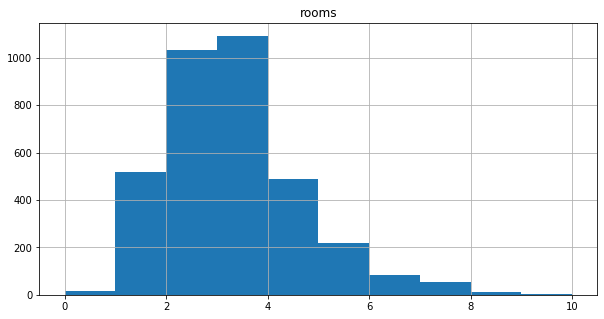

Минимальное значение rooms 0
Максимальное значение rooms 19


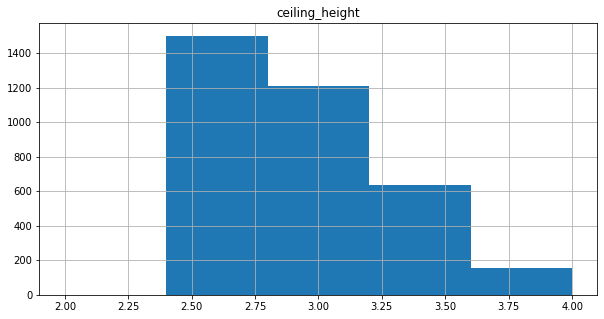

Минимальное значение ceiling_height 2.4
Максимальное значение ceiling_height 4.45


Посмотрим коэф-ты Пирсона для центра Санкт-Петербурга:

Кэф-т корреляции между ценой и числом комнат: 0.3148736324503905
Кэф-т корреляции между ценой и этажом: 0.10859658165008752
Кэф-т корреляции между ценой и удаленностью от центра: -0.04218576841424189

Посмотрим коэф-ты Пирсона для всего Санкт-Петербурга:

Кэф-т корреляции между ценой и числом комнат: 0.37237533826763347
Кэф-т корреляции между ценой и этажом: -0.0008379427208810821
Кэф-т корреляции между ценой и удаленностью от центра: -0.2595074646319885



In [4]:
#1
#Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.
def hist4(data):
    data.hist('total_area', bins=30, figsize=(10,5),range=(0,250))
    plt.show()
    print('Минимальное значение total_area', data['total_area'].min())
    print('Максимальное значение total_area', data['total_area'].max())
    
    data.hist('last_price', bins=25, figsize=(10,5), range=(0,30000000))
    plt.show()
    print('Минимальное значение last_price', data['last_price'].min())
    print('Максимальное значение last_price', data['last_price'].max())

    data.hist('rooms', bins=10, figsize=(10,5), range=(0,10))
    plt.show()
    print('Минимальное значение rooms', data['rooms'].min())
    print('Максимальное значение rooms', data['rooms'].max())
    
    data.hist('ceiling_height', bins=5, figsize=(10,5), range=(2,4))
    plt.show()
    print('Минимальное значение ceiling_height', data['ceiling_height'].min())
    print('Максимальное значение ceiling_height', data['ceiling_height'].max())
    print()

hist4(df)

#2
#Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. 
#Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?
df.hist('days_exposition', bins=70, range=(0, 800))
plt.show()

print('Минимльное время продажи квартиры:', df['days_exposition'].min())
print('Максимальное время продажи квартиры:', df['days_exposition'].max())
print('Среднее время продажи квартиры:', df['days_exposition'].mean())
print('Медианное время продажи квартиры:', df['days_exposition'].median())
print('За первую неделю продаётся квартир: {:.2%}'.format(len(df.query('days_exposition<=7'))/len(df)))
plt.show()

#3
#Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.


#4
#Какие факторы больше всего влияют на стоимость квартиры? 
#Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. 
#Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. 
#Также изучите зависимость от даты размещения: дня недели, месяца и года.
print()
print('Посмотрим коэф-ты корреляции с ценой:')
corr_df=df.corr()
print(corr_df.loc[:, 'last_price'].sort_values(ascending=False))
print()

def pivot_func(column):
    df_pivot=df.pivot_table(index=column, values='last_price', aggfunc=['median', 'mean']).reset_index()
    df_pivot.columns=[column, 'median_price', 'mean_price']
    df_pivot=df_pivot.sort_values(by='median_price').reset_index(drop=True)
    print()
    print(df_pivot)

pivot_func('floor_category')
pivot_func('weekday')
pivot_func('month')
pivot_func('year')


#5
#Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра 
#в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. 
#Эти данные можно найти по имени в столбце 'locality_name'.
print()
ten_most_pop=df.groupby('locality_name').agg({'total_images': ['count']}).reset_index()
ten_most_pop.columns=['locality_name', 'count']
ten_most_pop=ten_most_pop.sort_values(by='count', ascending=False).reset_index(drop=True).head(10)
print(ten_most_pop)
print()

a=pd.Series(ten_most_pop['locality_name'])
df_10pop=df.query('locality_name in @a')

df_pivot_10pop=df_10pop.pivot_table(index='locality_name', values='m2_price', aggfunc='mean').reset_index()
df_pivot_10pop.columns=['locality_name', 'mean_m2_price']
df_pivot_10pop=df_pivot_10pop.sort_values(by='mean_m2_price', ascending=False).reset_index(drop=True)
print()
print('10 населенных пунктов с самым большим кол-ом объявлений:')
print(df_pivot_10pop)
print('Среди 10 населенных пунктов с самым большим кол-вом объявлений самое дорогое жилье в: {}'.format(df_pivot_10pop.loc[0, 'locality_name']))
print('а самое дешевое в: {}'.format(df_pivot_10pop.loc[9, 'locality_name']))

#6
#Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра.
#Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. 
#Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. 
#После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, 
#как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.
df_spb=df.query('locality_name=="санкт-петербург"').reset_index(drop=True)
df_spb['cityCenters_km']=df_spb['cityCenters_nearest']/1000
df_spb['cityCenters_km']=df_spb['cityCenters_km'].round(0)

km_price=df_spb.groupby('cityCenters_km').agg({'last_price': ['mean']}).reset_index()
km_price.columns=['cityCenters_km', 'mean_price']

km_price.plot(x='cityCenters_km', y='mean_price', title='цена - удаленность от центра', style='o-',grid=True)#, figsize=(10,10))
plt.show()
print()

#7
#Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, 
#высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, 
#дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?
df_centre=df_spb.query('cityCenters_km<=7')

hist4(df_centre)

def corr_centre_spb(data):
    print()
    print('Кэф-т корреляции между ценой и числом комнат:', data['last_price'].corr(data['rooms']))
    print('Кэф-т корреляции между ценой и этажом:', data['last_price'].corr(data['floor']))
    print('Кэф-т корреляции между ценой и удаленностью от центра:', data['last_price'].corr(data['cityCenters_nearest']))
    print()

print()
print('Посмотрим коэф-ты Пирсона для центра Санкт-Петербурга:')
corr_centre_spb(df_centre)


print('Посмотрим коэф-ты Пирсона для всего Санкт-Петербурга:')
corr_centre_spb(df_spb)

**Вывод**  

1.
Из гистограмм видно:  
площадь большинства квартир лежит в пределах от 25 до 100 м2, а квартиры площадью больше 150 кв.м. встречаются очень  редко;  
цена большинства квартир 1-9 млн;  
кол-во комнат большинства квартир составяет 1, 2 или 3 комнаты;  
чаще всего высота потолков в квартирах составляет 2.4-3 м

2.
Половина квартир продается в течени 3-х месяцев. Около 4-х процентов продается уже в первую неделю публикации, это можно назвать очень быстрой продажей. Продажи дольше 300 дней можно назвать небычно долгими

3.
Я уже удалила выбивающиеся значения в столбце ceiling_height. В других столбах тоже есть выдающиеся значения, но я не хочу их удалять, так как они выглядят вполне реалистично.

4.
Больше всего на стоимость квартиры влиют: площадь и кол-во комнат. Чуть меньше - высота потолка, близость к центру города, а также наличие по близости парков и водоемов.  
Вычесленные коэффициенты корреляции говорят о седующем:  
Цена квартиры довольно сильно зависит от кол-ва квадратных метров (k=0.65) и от кол-ва комнат (k=0.36). Чем больше кв.метров или комнат, тем выше цена.  
Цена обратно пропорциональна удаленности от центра (k=-0.2). Чем дальше от центра расположена квартира, тем она дешевле.
Эти выводы очевидны, а также мы их подтвердили расчетами.  
Самые дешевые вартиры расположены на 1-м этаже, чуть дороже - на последнем. Все остальные этажи оцениваются дороже.
День недели или месяц публикации объявления практически никак не влияют на цену квартиры.  
В 2015 году средняя цена на квартиру подешевела на примерно 30%. Далее до 2017 года средняя цена продолжала снижаться, но уже не так стремительно. В 2018-2019 гг цена немного стала расти.

5.
10 населённых пунктов с наибольшим числом объявлений: санкт-петербург, поселок мурино, поселок шушары, всеволожск, пушкин, колпино, поселок парголово, гатчина, деревня кудрово, выборг. 

6.
Построив график зависимости цены от удаленности от центра я заметила, что примерно после значения 7 км график начинает "сглаживаться", то есть цена перестает так сильно зависеть от удалености. Определю 7 км как границу центральной зоны.

7.
Из гистограмм видно, что в центра Санкт-Петербурга:  
-площадь большинства квартир лежит в пределах от 25 до 150 м2  
-цена большинства квартир 4-15 млн  
-кол-во комнат большинства квартир составяет 1, 2 или 3 комнаты  
-чаще всего высота потолков в квартирах составляет 2.4-3.5 м  

В центре Санкт-Петербурга цена квартиры сильно зависит от кол-ва комнат и немного зависит от этажа. В пределах обозначенной мной центральной зоны в 7 км цена от местоположения не зависит.  
В общем по Санкт-Петербургу цена также зависит от кол-ва комнат, однако совершенно не зависит от этажа. Удаленность от центра сильно влияет на цену квартиры в городе.




### Общий вывод

Чаще всего продаются квартиры площадью 25-100 кв.м., с высотой потолков 2.4-3м. Это 1,2 и реже 3 комнатные. Стоимость таких квартир ориентировочно 1-9 млн. В среднем они продаются в течении года.

В центре Санкт-Петербурга цена уже выше (4-15 млн.). Чаще встречаются 2-3 комнатные, и лишь потом 1 и 4-х комн. квартиры. 

На стоимость квартир больше всего влияют площадь и кол-во комнат. Последние несколько лет (2018-2019) стоимость квартир немного растет. 

Больше всего объявлений разещено о квартирах, расположенных в Санкт-Петербурге, средняя цена таких квартир 114849 за кв.м.

